In [1]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import cv2
from PIL import Image
import random
from glob import glob
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Recall, Precision

In [2]:
import os
tf.random.set_seed(42)

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/project.kaggle"

In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
!kaggle datasets download -d balraj98/deepglobe-road-extraction-dataset

  0% 14.0M/3.79G [00:01<05:40, 11.9MB/s]User cancelled operation
  0% 17.0M/3.79G [00:02<07:50, 8.61MB/s]


In [ ]:
!unzip \*.zip  && rm *.zip

Archive:  deepglobe-road-extraction-dataset.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of *.zip or
        *.zip.zip, and cannot find deepglobe-road-extraction-dataset.zip.ZIP, period.

No zipfiles found.


In [3]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection

        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)


smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true*y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))


def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [4]:
# load Data
data_path = "/content/drive/MyDrive/train"
train_y = sorted(glob(data_path + '/*mask.png'))
train_x = sorted(glob(data_path + '/*sat.jpg'))
print(len(train_y), len(train_x))

6226 6226


In [5]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
kernel_initializer =  'he_uniform'
batch_size=10
prefetch_buffer = 1
lr = 1e-4 #0.0001
num_epochs = 10

In [6]:
def read_image(path):
    try:
        img = Image.open(path)
        img = img.resize((IMG_WIDTH, IMG_HEIGHT))
        x = np.array(img, dtype=np.float32)
        x = x / 255.0
        return x
    except Exception as e:
        print(f"Error while reading image: {e}")
        return None


def read_mask(path):
    try:
        img = Image.open(path).convert('L')
        img = img.resize((IMG_WIDTH, IMG_HEIGHT))
        x = np.array(img, dtype=np.float32)
        x = x / 255.0
        x = np.expand_dims(x, axis=-1)
        return x
    except Exception as e:
        print(f"Error while reading mask: {e}")
        return None


def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([IMG_HEIGHT,IMG_WIDTH, 3])
    y.set_shape([IMG_HEIGHT,IMG_WIDTH, 1])
    return x, y




def tf_dataset(X, Y, batch_size, prefetch_buffer, validation_split=0.2, seed=None):
    # Combine X and Y into a single dataset
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)

    # Shuffle the dataset if you want a random order
    if seed is not None:
        dataset = dataset.shuffle(buffer_size=len(X), seed=seed)

    # Calculate the number of samples for the validation split
    num_samples = len(X)
    num_validation_samples = int(validation_split * num_samples)

    # Split the dataset into training and validation sets
    train_dataset = dataset.skip(num_validation_samples)
    validation_dataset = dataset.take(num_validation_samples)

    # Batch and prefetch the training and validation datasets
    train_dataset = train_dataset.batch(batch_size).prefetch(prefetch_buffer)
    validation_dataset = validation_dataset.batch(batch_size).prefetch(prefetch_buffer)

    return train_dataset, validation_dataset


In [7]:
def show_random_sample():
    rand_index =random.randint(0, len(train_x) - 1)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(read_image(train_x[rand_index]))
    plt.title('Image')

    plt.subplot(1, 2, 2)
    plt.imshow(read_mask(train_y[rand_index]))
    plt.title('Mask')

    plt.show()

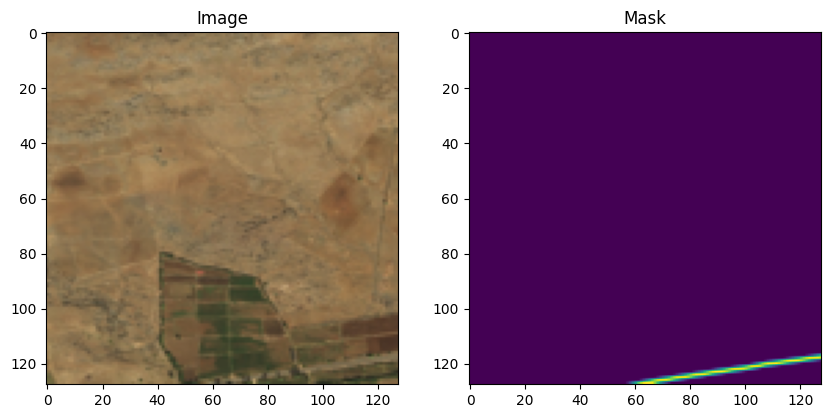

In [8]:
show_random_sample()

In [9]:
train_dataset, validation_dataset = tf_dataset(train_x, train_y, batch_size, prefetch_buffer, validation_split=0.2, seed=42)


In [ ]:

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    metrics = [dice_coef, iou, Recall(), Precision()]
    model.compile(optimizer=Adam(lr), loss='binary_crossentropy', metrics=metrics)
    #model.compile(optimizer=Adam(lr = 1e-3), loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2)])
    model.summary()

    return model

In [ ]:
model =simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [ ]:
#Model checkpoint
checkpointer =  tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/project.kaggle/U_net_model',verbose=1,save_best_only=True)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2,monitor='iou'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(train_dataset,epochs=num_epochs,callbacks=callbacks)

Epoch 1/10
499/499 [==============================] - 286s 35ms/step - loss: 0.1191 - dice_coef: 0.2281 - iou: 0.1292 - recall: 0.0809 - precision: 0.8173
Epoch 2/10
499/499 [==============================] - 281s 36ms/step - loss: 0.1189 - dice_coef: 0.2319 - iou: 0.1317 - recall: 0.0871 - precision: 0.8195
Epoch 3/10
499/499 [==============================] - 285s 35ms/step - loss: 0.1175 - dice_coef: 0.2394 - iou: 0.1365 - recall: 0.0963 - precision: 0.8207
Epoch 4/10
499/499 [==============================] - 293s 35ms/step - loss: 0.1160 - dice_coef: 0.2480 - iou: 0.1422 - recall: 0.1062 - precision: 0.8274
Epoch 5/10
499/499 [==============================] - 289s 36ms/step - loss: 0.1152 - dice_coef: 0.2559 - iou: 0.1474 - recall: 0.1149 - precision: 0.8246
Epoch 6/10
499/499 [==============================] - 292s 35ms/step - loss: 0.1141 - dice_coef: 0.2628 - iou: 0.1519 - recall: 0.1227 - precision: 0.8278
Epoch 7/10
499/499 [==============================] - 300s 35ms/step -

In [ ]:
model.save('/content/drive/MyDrive/U_net_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
from tensorflow import keras

tf.keras.utils.get_custom_objects()['dice_coef'] = dice_coef
tf.keras.utils.get_custom_objects()['iou'] = iou


model_path = '/content/drive/MyDrive/U_net_model.h5'
loaded_model = keras.models.load_model(model_path)

In [11]:
metrics = [dice_coef, iou, Recall(), Precision()]

loaded_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

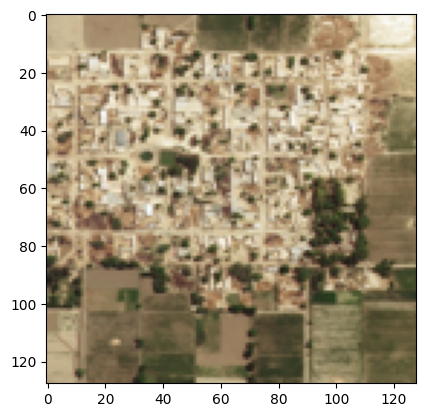

In [12]:
img =read_image("/content/drive/MyDrive/test/100393_sat.jpg")
plt.imshow(img)

In [13]:
img = np.expand_dims(img, axis=0)
img.shape

(1, 128, 128, 3)

1/1 [==============================] - 9s 9s/step


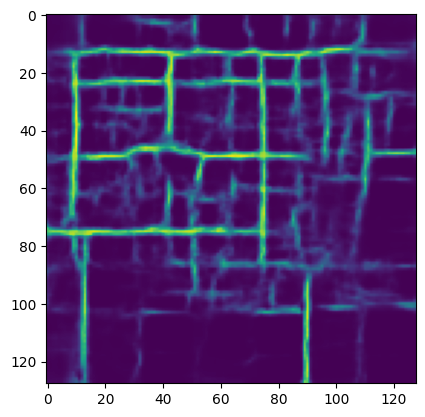

In [14]:
pred = loaded_model.predict(img)
plt.imshow(pred[0,...])

In [15]:
#Model checkpoint
checkpointer =  tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/project.kaggle/U_net_model',verbose=1,save_best_only=True)
callbacks = [
    #tf.keras.callbacks.EarlyStopping(patience=2,monitor='iou'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = loaded_model.fit(train_dataset,epochs=num_epochs,callbacks=callbacks)

Epoch 1/10
499/499 [==============================] - 310s 34ms/step - loss: 0.0986 - dice_coef: 0.3598 - iou: 0.2204 - recall: 0.2332 - precision: 0.8736
Epoch 2/10
499/499 [==============================] - 281s 33ms/step - loss: 0.0979 - dice_coef: 0.3619 - iou: 0.2219 - recall: 0.2337 - precision: 0.8762
Epoch 3/10
499/499 [==============================] - 284s 32ms/step - loss: 0.0976 - dice_coef: 0.3708 - iou: 0.2288 - recall: 0.2425 - precision: 0.8788
Epoch 4/10
499/499 [==============================] - 297s 33ms/step - loss: 0.0945 - dice_coef: 0.3822 - iou: 0.2373 - recall: 0.2528 - precision: 0.8827
Epoch 5/10
499/499 [==============================] - 305s 33ms/step - loss: 0.0946 - dice_coef: 0.3843 - iou: 0.2389 - recall: 0.2534 - precision: 0.8860
Epoch 6/10
499/499 [==============================] - 292s 33ms/step - loss: 0.0925 - dice_coef: 0.3904 - iou: 0.2436 - recall: 0.2593 - precision: 0.8893
Epoch 7/10
499/499 [==============================] - 292s 33ms/step -

In [16]:
loaded_model.save('/content/drive/MyDrive/U_net_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
import random
import matplotlib.pyplot as plt
import os
import cv2

# Define the path to your test data directory
test_data_path = "/content/drive/MyDrive/test"

# List all image file names in the test data directory
test_samples = [file for file in os.listdir(test_data_path) if file.endswith("sat.jpg")]

# Randomly select 10 samples from the list
sample_indices = random.sample(test_samples, 10)

for i, image_filename in enumerate(sample_indices, 1):
    image_path = os.path.join(test_data_path, image_filename)

    img = read_image(image_path)
    img = np.expand_dims(img, axis=0)

    pred = loaded_model.predict(img)

    # Create a new figure for each image and prediction
    plt.figure(figsize=(6, 4))

    # Plot the input image
    plt.subplot(1, 2, 1)
    plt.imshow(img[0, ...])  # Display the input image
    plt.title(f'Sample {i}\nInput Image')
    plt.axis('off')

    # Plot the model's prediction
    plt.subplot(1, 2, 2)
    plt.imshow(pred[0, ...])  # Display the prediction
    plt.title('Model Prediction')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.